In [2]:
#@title To mount drive to colab { display-mode: "form" }
# codes to mount your google drive folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_NLP


In [3]:
#@title Download Huggingface packages
#Install hugging face packages

!pip install transformers
!pip install datasets
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 4.9 MB/s 
     |████████████████████████████████| 212 kB 73.6 MB/s 
     |████████████████████████████████| 1.1 MB 66.6 MB/s 
     |████████████████████████████████| 140 kB 76.5 MB/s 
     |████████████████████████████████| 127 kB 76.7 MB/s 
     |████████████████████████████████| 271 kB 74.4 MB/s 
     |████████████████████████████████| 144 kB 43.6 MB/s 
     |█████████████

In [4]:
#@title Import necessary libraries and frameworks
#Necessary libraries and frameworks

import transformers
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW, lr_scheduler
from datasets import load_metric
from accelerate import Accelerator
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
transformers.logging.set_verbosity_error()

In [5]:
# file names
laptop_path = "./Group Project/laptoptrain.csv"
restaurant_path = "./Group Project/restauranttrain.csv"

In [7]:
#@title class PreProcessor
# codes are revised from Lecture 6's Code Lab
class InputExample(object):
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

class InputFeatures(object):
    def __init__(self, input_ids, attention_mask=None, token_type_ids=None, label=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

class PreProcessor():
    
    def __init__(self):
        self.model_args = {'max_seq_length':64, 'verbose':False}
    
    def set_model_arg(self, key, value):
        self.model_args[key] = value
    
    def get_model_arg(self, key):
        return self.model_args.get(key, None)
        return self.avg_seq_length
    
    def getDF(self, path, col):
        df = pd.read_csv(path)
        df = df[df[col]!='nan']
        df = df[~df[col].isnull()]
        return df
    
    def split_set(self,path,col, frac=0.8):
        trainset=self.getDF(path,col).sample(frac=frac,random_state=42,axis=0)    
        validationset=self.getDF(path,col)[~self.getDF(path,col).index.isin(trainset.index)]
        trainset=trainset.reset_index()
        validationset=validationset.reset_index()
        
        return trainset, validationset

    def get_labels(self):
        return ["neutral", "positive", "negative", "conflict"]

    def _create_examples(self, df, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for i in range(len(df)):
            guid = "%s-%s" % (set_type, i)
            label = df.loc[i,"polarity"]

            text_a = df.loc[i,"text"]
            text_b = df.loc[i,"term"]
            
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples
    
    def convert_examples_to_features(self, tokenizer, examples, is_test=False):
        max_length = self.get_model_arg("max_seq_length")
        label_list = self.get_labels()
        pad_token = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
        label_map = {label: i for i, label in enumerate(label_list)}
        
        features = []
        for (ex_index, example) in enumerate(examples):
            inputs = tokenizer.encode_plus(
                example.text_a,
                example.text_b,
                truncation='longest_first',
                add_special_tokens=True,
                max_length=max_length,
            )
            input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            attention_mask = [1] * len(input_ids)

            # Zero-pad up to the sequence length.
            padding_length = max_length - len(input_ids)

            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)

            assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
            assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
            assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)

            
            label = label_map[example.label]

            # if ex_index < 5 and self.get_model_arg('verbose'):
            #     print("*** Example ***")
            #     print("guid: %s" % (example.guid))
            #     print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            #     print("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            #     print("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            #     if not is_test:
            #         print("label: %s (id = %d)" % (example.label, label))
            #     else:
            #         print("index: %s " % (example.label))

            features.append(
                    InputFeatures(input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  token_type_ids=token_type_ids,
                                  label=label))
        return features
    
    def convert_feature_to_dataset(self, features):
        # Convert to Tensors and build dataset
        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        
        return dataset
    
    def get_dataloader(self, features, batch_size, is_test=False, drop_last=True):
        dataset = self.convert_feature_to_dataset(features)

        dataset_sampler = SequentialSampler(dataset) if is_test else RandomSampler(dataset)

        dataloader = DataLoader(dataset, sampler=dataset_sampler, batch_size=batch_size, drop_last=drop_last)
        return dataloader
    
    def get_data_iter(self, features, batch_size, is_test=False, drop_last=True):
        dataloader = self.get_dataloader(features, batch_size, is_test=is_test, drop_last=drop_last)
        return iter(dataloader)

In [8]:
#@title utility functions

def check_gpu():
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU used")
    return device

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)



In [9]:
#@title Training Function
# training function

def train(model, tokenizer, proc, device, train_df, valid_df):
    # fetch hyper-parameters
    batch_size = proc.get_model_arg("batch_size")
    n_epochs = proc.get_model_arg('n_epochs')
    learning_rate = proc.get_model_arg("learning_rate")
    adam_epsilon = proc.get_model_arg('adam_epsilon')
    weight_decay = proc.get_model_arg('weight_decay')
    verbose = proc.get_model_arg("verbose")
    log_step = proc.get_model_arg("log_step")
    checkpoint_path = proc.get_model_arg("checkpoint_path")
    max_seq_length = proc.get_model_arg("max_seq_length")
    clip = proc.get_model_arg("clip")
    data_path = proc.get_model_arg("dataset_path")
    
    # prepare training dataset
    examples = proc._create_examples(train_df, "train")
    features = proc.convert_examples_to_features(tokenizer, examples)
    data_iter = proc.get_data_iter(features, batch_size)
    # training steps in each epoch
    examples_total_num = len(features)
    max_steps = math.ceil(float(examples_total_num)/batch_size)
    t_total = max_steps * n_epochs
    
    # Define Loss, Optimizer
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = lr_scheduler.LinearLR(optimizer, total_iters=t_total)

    # Record training history
    epochs = []
    train_batch_accuracy = []
    train_epoch_accuracy = []
    train_batch_loss = []
    train_epoch_loss = []

    valid_batch_accuracy = []
    valid_epoch_accuracy = []
    valid_batch_loss = []
    valid_epoch_loss = []

    # train!
    for epoch in range(n_epochs):
        total_loss = 0.0
        for step in range(max_steps):
            model.train()
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            # prepare inputs
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = proc.get_data_iter(features, batch_size)
                batch = next(data_iter)

            batch = tuple(t.to(device) for t in batch)

            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         batch[3]}

            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
            loss.backward()
            # clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            
            total_loss += loss.item()
            if step%log_step==0:
                train_loss_metric, train_accuracy_metric, size_t = evaluate(model, tokenizer, proc, device, train_df)
                print("step: {}/{}, Loss: {:.4f}, train: {}, size:{}".format(step, max_steps, train_loss_metric, train_accuracy_metric, size_t))
                train_batch_loss.append(train_loss_metric)
                train_batch_accuracy.append(train_accuracy_metric['accuracy'])

                valid_loss_metric, valid_accuracy_metric, size_v = evaluate(model, tokenizer, proc, device, valid_df)
                print("step: {}/{}, Loss: {:.4f}, valid: {}, size:{}".format(step, max_steps, valid_loss_metric, valid_accuracy_metric, size_v))
                print("\n")
                valid_batch_loss.append(valid_loss_metric)
                valid_batch_accuracy.append(valid_accuracy_metric['accuracy'])

        train_loss_metric, train_accuracy_metric, size = evaluate(model, tokenizer, proc, device, train_df)
        print("EPOCH: {}/{}, Loss: {:.4f}, eval_metric: {}".format(epoch, n_epochs, train_loss_metric, train_accuracy_metric))        
        train_epoch_loss.append(train_loss_metric)
        train_epoch_accuracy.append(train_accuracy_metric['accuracy'])
        
        valid_loss_metric, valid_accuracy_metric, size = evaluate(model, tokenizer, proc, device, valid_df)
        print("EPOCH: {}/{}, Loss: {:.4f}, eval_metric: {}".format(epoch, n_epochs, valid_loss_metric, valid_accuracy_metric))
        print("\n")
        valid_epoch_loss.append(valid_loss_metric)
        valid_epoch_accuracy.append(valid_accuracy_metric['accuracy'])

        epochs.append(epoch)
    return {
    'epochs': epochs,
    'train_batch_accuracy' : train_batch_accuracy,
    'train_epoch_accuracy' : train_epoch_accuracy,
    'train_batch_loss' : train_batch_loss,
    'train_epoch_loss' : train_epoch_loss,

    'valid_batch_accuracy' : valid_batch_accuracy,
    'valid_epoch_accuracy' : valid_epoch_accuracy,
    'valid_batch_loss' : valid_batch_loss,
    'valid_epoch_loss' : valid_epoch_loss
    }

In [10]:
#@title Evaluation Function
def evaluate(model, tokenizer, proc, device, df):
    # fetch hyper-parameters
    batch_size = len(df) #proc.get_model_arg("batch_size")
    n_epochs = proc.get_model_arg('n_epochs')
    learning_rate = proc.get_model_arg("learning_rate")
    adam_epsilon = proc.get_model_arg('adam_epsilon')
    weight_decay = proc.get_model_arg('weight_decay')
    verbose = proc.get_model_arg("verbose")
    log_step = proc.get_model_arg("log_step")
    checkpoint_path = proc.get_model_arg("checkpoint_path")
    max_seq_length = proc.get_model_arg("max_seq_length")
    clip = proc.get_model_arg("clip")
    data_path = proc.get_model_arg("dataset_path")

    metric = load_metric("glue", "rte")
    accelerator = Accelerator()
    
    # prepare dataset
    examples = proc._create_examples(df, "valid")
    features = proc.convert_examples_to_features(tokenizer, examples)
    eval_dataloader = proc.get_dataloader(features, batch_size)
    
    for batch in eval_dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = accelerator.gather((predictions, inputs["labels"]))
        #print("predictions:", predictions)
        metric.add_batch(
                predictions=predictions,
                references=references,
            )
        eval_metric = metric.compute()

    return loss, eval_metric, len(df)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
#@title Hyper parameters Setup
# preprare dataset and hyper-parameters for training
proc = PreProcessor()

# hyper-parameters for data
proc.set_model_arg('batch_size',4)
proc.set_model_arg('max_seq_length', 64)
# hyper-parameters for model
proc.set_model_arg('learning_rate', 1e-6)
proc.set_model_arg('n_epochs', 5)
proc.set_model_arg('warmup_steps', 0.06)
proc.set_model_arg('weight_decay', 0.2)
proc.set_model_arg('adam_epsilon', 1e-8)
proc.set_model_arg('clip', 1)

# arguments for reproduction
proc.set_model_arg('log_step', 30)
proc.set_model_arg('verbose', True)    # if log details
proc.set_model_arg('init_seed', 42)


In [13]:
#@title Prepare model from HuggingFace & start training
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=4)

# get parameters from preprocessor
init_seed = proc.get_model_arg('init_seed')
proc.set_model_arg('verbose', False)

device = check_gpu()
set_seed(init_seed)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

train_df, valid_df = proc.split_set(laptop_path,"term")
#training the model
train_history = train(model, tokenizer, proc, device, train_df, valid_df)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

GPU is available


step: 0/475, Loss: 1.4536, train: {'accuracy': 0.2766069546891465}, size:1898
step: 0/475, Loss: 1.4456, valid: {'accuracy': 0.30105263157894735}, size:475


step: 30/475, Loss: 1.4453, train: {'accuracy': 0.29083245521601686}, size:1898
step: 30/475, Loss: 1.4395, valid: {'accuracy': 0.30526315789473685}, size:475


step: 60/475, Loss: 1.4376, train: {'accuracy': 0.3029504741833509}, size:1898
step: 60/475, Loss: 1.4327, valid: {'accuracy': 0.3136842105263158}, size:475


step: 90/475, Loss: 1.4293, train: {'accuracy': 0.3177028451001054}, size:1898
step: 90/475, Loss: 1.4252, valid: {'accuracy': 0.32842105263157895}, size:475


step: 120/475, Loss: 1.4222, train: {'accuracy': 0.3398314014752371}, size:1898
step: 120/475, Loss: 1.4186, valid: {'accuracy': 0.3410526315789474}, size:475


step: 150/475, Loss: 1.4145, train: {'accuracy': 0.35932560590094836}, size:1898
step: 150/475, Loss: 1.4120, valid: {'accuracy': 0.35368421052631577}, size:475


step: 180/475, Loss: 1.4075, train: {'

In [27]:
#@title Plotting loss and accuracy of training history
# Create a function to plot loss and accuracy
def plot_curve(hist):
    """Plot a curve of one or more classification metrics"""  
    epochs = range(80)
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
    # Loss after batch
    ax[0,0].plot(epochs, hist['train_batch_loss'], label='Training Loss')
    ax[0,0].plot(epochs, hist['valid_batch_loss'], label='Validation Loss')
    ax[0,0].set_xlabel('Batches')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].legend()
    ax[0,0].set_xticks(range(0,80,5))
    min_0 = min(min(hist['train_batch_loss']),min(hist['valid_batch_loss']))
    max_0 = max(max(hist['train_batch_loss']),max(hist['valid_batch_loss']))
    ax[0,0].set_ylim([min_0*0.95, max_0 * 1.1])
    ax[0,0].set_title('Loss by batch', fontweight ="bold")
    # Accuracy after each batch
    ax[0,1].plot(epochs, hist['train_batch_accuracy'], label='Training Accuracy')
    ax[0,1].plot(epochs, hist['valid_batch_accuracy'], label='Validation Accuracy')
    ax[0,1].set_xlabel('Batches')
    ax[0,1].set_ylabel('Accuracy')
    ax[0,1].legend()
    ax[0,1].set_xticks(range(0,80,5))
    min_1 = min(min(hist['train_batch_accuracy']),min(hist['valid_batch_accuracy']))
    max_1 = max(max(hist['train_batch_accuracy']),max(hist['valid_batch_accuracy']))
    ax[0,1].set_ylim([min_1*0.95, max_1 * 1.1])
    ax[0,1].set_title('Accuracy by batch', fontweight ="bold")

    # Loss after each Epoch
    epochs = range(5)
    ax[1,0].plot(epochs, hist['train_epoch_loss'], label='Training Loss')
    ax[1,0].plot(epochs, hist['valid_epoch_loss'], label='Validation Loss')
    ax[1,0].set_xlabel('Epochs')
    ax[1,0].set_ylabel('Loss')
    ax[1,0].legend()
    ax[1,0].set_xticks(range(5))
    min_2 = min(min(hist['train_epoch_loss']),min(hist['valid_epoch_loss']))
    max_2 = max(max(hist['train_epoch_loss']),max(hist['valid_epoch_loss']))
    ax[1,0].set_ylim([min_2*0.95, max_2 * 1.1])
    ax[1,0].set_title('Loss by epoch', fontweight ="bold")
    # Accuracy after each Epoch
    ax[1,1].plot(epochs, hist['train_epoch_accuracy'], label='Training Accuracy')
    ax[1,1].plot(epochs, hist['valid_epoch_accuracy'], label='Validation Accuracy')
    ax[1,1].set_xlabel('Epochs')
    ax[1,1].set_ylabel('Accuracy')
    ax[1,1].legend()
    ax[1,1].set_xticks(range(5))
    min_3 = min(min(hist['train_epoch_accuracy']),min(hist['valid_epoch_accuracy']))
    max_3 = max(max(hist['train_epoch_accuracy']),max(hist['valid_epoch_accuracy']))
    ax[1,1].set_ylim([min_3*0.95, max_3 * 1.1])
    ax[1,1].set_title('Accuracy by epoch', fontweight ="bold")




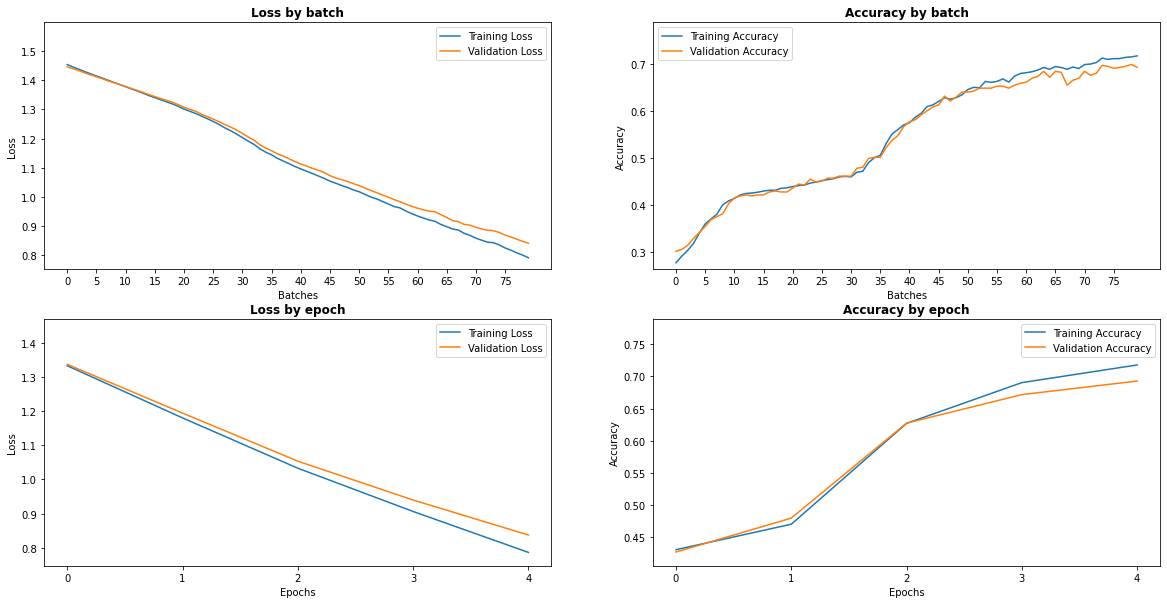

In [28]:
# plotting loss and accurracy
train_history_cpu = {k: [i.to(device='cpu', non_blocking=True).numpy() if hasattr(i, 'to') else i for i in v] for k, v in train_history.items()}
plot_curve(train_history_cpu)

In [29]:
#@title Saving model
#Saving model
proc.set_model_arg('checkpoint_path', "./Group Project/model_subtask2_approach2.bin")
checkpoint_path = proc.get_model_arg("checkpoint_path")
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

save_model(model, checkpoint_path)

In [30]:
#@title Print out predicted results for test dataset

def print_output(model, tokenizer, proc, device, df ):
    batch_size = len(df)
    data_path = proc.get_model_arg("dataset_path")

    # prepare dataset
    examples = proc._create_examples(df, "valid")
    features = proc.convert_examples_to_features(tokenizer, examples)
    test_dataloader = proc.get_dataloader(features, batch_size, is_test = True)

    # accelerator = Accelerator()

    with open('nlp_assign2_submission.txt', 'w') as f:    
        for batch in test_dataloader:
            model.eval()
            batch = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'token_type_ids': batch[2],
                          'labels':         batch[3]}
                outputs = model(**inputs)
            predictions = outputs.logits.argmax(dim=-1)
            label_map = {0:"neutral", 1:"positive", 2:"negative", 3:"conflict"}
            pred_value = [label_map[i] for i in predictions.cpu().numpy()]
            df['pred_value'] = pred_value
    return df

pred_df = print_output(model, tokenizer, proc, device, valid_df )

In [37]:
# Correct predictions
pred_df[pred_df['polarity']==pred_df['pred_value']]

,index,id,text,term,polarity,from,to,pred_value
0,1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74.0,86.0,positive
2,15,76,"I even got my teenage son one, because of the ...",iChat,positive,77.0,82.0,positive
3,22,917,One night I turned the freaking thing off aft...,screen,negative,94.0,100.0,negative
4,26,338,"My only disappointment with the 13"" model is t...",processor,negative,119.0,128.0,negative
8,51,743,When I finally had everything running with all...,system,negative,111.0,117.0,negative
...,...,...,...,...,...,...,...,...
467,3846,1258,It seemed to be a very nice laptop except I wa...,Microsoft Office 2003,negative,91.0,112.0,negative
468,3848,63,I've also had to have the keyboard replaced at...,keyboard,negative,26.0,34.0,negative
469,3870,29,"I had to adjust my mousepad sensitivity, becau...",mousepad sensitivity,negative,19.0,39.0,negative
471,3887,712,"I love my Apple, it is quick and easy to use.",use,positive,41.0,44.0,positive


In [35]:
# Wrong predictions
pred_df[pred_df['polarity']!=pred_df['pred_value']]

,index,id,text,term,polarity,from,to,pred_value
1,5,1316,The tech guy then said the service center does...,tech guy,neutral,4.0,12.0,negative
5,28,338,"My only disappointment with the 13"" model is t...",battery life,positive,205.0,217.0,negative
6,29,1630,I took it back for an Asus and same thing- blu...,battery,neutral,87.0,94.0,negative
7,50,743,When I finally had everything running with all...,software,neutral,50.0,58.0,negative
10,81,839,I sent it back to Toshiba twice they covered i...,warranty,positive,59.0,67.0,negative
...,...,...,...,...,...,...,...,...
456,3814,1415,"In all honesty, if someone is looking for a qu...",sized,neutral,111.0,116.0,positive
461,3831,778,I spoke with a service rep at Micro Center and...,service rep,neutral,15.0,26.0,negative
470,3886,2299,You can do it all on this bad boy but the main...,surfing the web,positive,87.0,102.0,negative
472,3891,506,With notes saying they replaced the hard drive.,hard drive,neutral,36.0,46.0,negative


In [36]:
# download prediction file
from google.colab import files

pred_df.to_csv('pred_df_approach2.csv')
files.download('pred_df_approach2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>